##**Advanced Topics in Machine Learning**
#### Assignment 2
- Joona Kareinen, Premek Janda, Filippo Torrisi, Simone Mugnai


As project for our second assignment we decided to take as inspiration the SQuAD2.0: The Stanford Question Answering Dataset, as requested we divide our task into four parts, from investigation of the dataset to train and testing of the models:
## Investigate Dataset
In this phase, we embark on a comprehensive exploration of the chosen dataset.  Drawing inspiration from earlier tutorial notebooks, we engage with the dataset through practical exercises. This includes training a Word2Vec embedding to unveil intrinsic properties and optimizing document indexing for efficient keyword searches.

## Train the Models

For the training and evaluation of models tailored to specific tasks within each dataset. This encompasses fine-tuning Transformers, LSTMs, or linear models using designated training data. Simultaneously, we explore the potential of leveraging pre-trained models available on the Hugging Face website. A crucial aspect of our analysis revolves around assessing the efficacy of Large Language Models (LLMs).

## Add Voice Interactivity
We introduce voice interactivity to the most adept chatbot/question-answering system identified earlier. This entails the integration of text-to-speech and speech-to-text models. Our investigation extends to evaluating the effectiveness and reliability of these voice interactive components.

## Potential Extensions
We implemented an app

### Installing Python packages

In [ ]:
!pip install plotly sentence_transformers hnswlib


We copyed the Github repository in order to upload the data on Colab


In [1]:
import os.path

path = './train-v2.0.json'

check_file = os.path.isfile(path)
if not check_file:
  !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json


#### Data loading

In this section we pre-process the train dataset provided by Stanford University. \\
In order to prepare the data for our subsequent task we split it according to the context, question and answer.

In [3]:
import json
import numpy as np

# Open the data file
file_path = './train-v2.0.json'
with open(file_path, 'rb') as f:
    # Load the data
    data_dict = json.load(f)


unique_contexts = []
contexts = []
pairs = []
for category in data_dict["data"]:
    for passage in category["paragraphs"]:
        context = passage["context"]
        unique_contexts.append(context)
        for qa in passage["qas"]:
            question = qa["question"]
            for answer in qa["answers"]:
                pairs.append([question, answer])
                contexts.append(context)


# Print some data
num_titles = len(unique_contexts)
print(f"In the dataset there are {num_titles} different categories with total of {len(pairs)} question/answer pairs.")
# Test that the data was loaded correctly

# Print 5 random question and answer pairs
idx = np.random.choice(len(pairs), 5)
for id in idx:
    print(f"Q: {pairs[id][0]}")
    print(f"A: {pairs[id][1]['text']}")
    print()


In the dataset there are 19035 different categories with total of 86821 question/answer pairs.
Q: Greek merchants ruled the trade industry in which century?
A: 18th

Q: In what century was Old English first used?
A: 5th

Q: Who said a showdown between Japan and the United States would be necessary?
A: Admiral Sankichi Takahashi

Q: Who sent the Byzantine craftsmen that built Yaroslav's cathedral?
A: Constantine Monomachos

Q: What language does the name of the Niger River come from?
A: Tuareg



## Text Preprocessing Pipeline:
 We perform data normalization and processing to generate pairs and sentence arrays for training purposes in the context of Word2Vec.

In [4]:
import re
from pandas.core.common import flatten
import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s, is_answer):
    # Lowercase
    s = s.lower()
    s = unicodeToAscii(s)
    # Do some pruning to the data
    s = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', s)
    s = re.sub('\W', ' ', s).lower().split()

    return s

tokenized_sentences = []
for idx, pair in enumerate(pairs):
    s1 = normalizeString(pair[0], 0)
    s2 = normalizeString(pair[1]["text"], 1)
    if len(s1) > 1 and len(s2) > 1:
        tokenized_sentences.append(s1)
        tokenized_sentences.append(s2)

for sentence in tokenized_sentences[:10]:
    print(sentence)


['when', 'did', 'beyonce', 'start', 'becoming', 'popular']
['in', 'the', 'late', '1990s']
['what', 'areas', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up']
['singing', 'and', 'dancing']
['in', 'what', 'city', 'and', 'state', 'did', 'beyonce', 'grow', 'up']
['houston', 'texas']
['in', 'which', 'decade', 'did', 'beyonce', 'become', 'famous']
['late', '1990s']
['in', 'what', 'r', 'b', 'group', 'was', 'she', 'the', 'lead', 'singer']
['destiny', 's', 'child']


## Exploratory Analysis:
We perform a simple exploratory analysis about our data, in particular we count for unique words and plot the distribution of lenght of the sentences together with the average count.

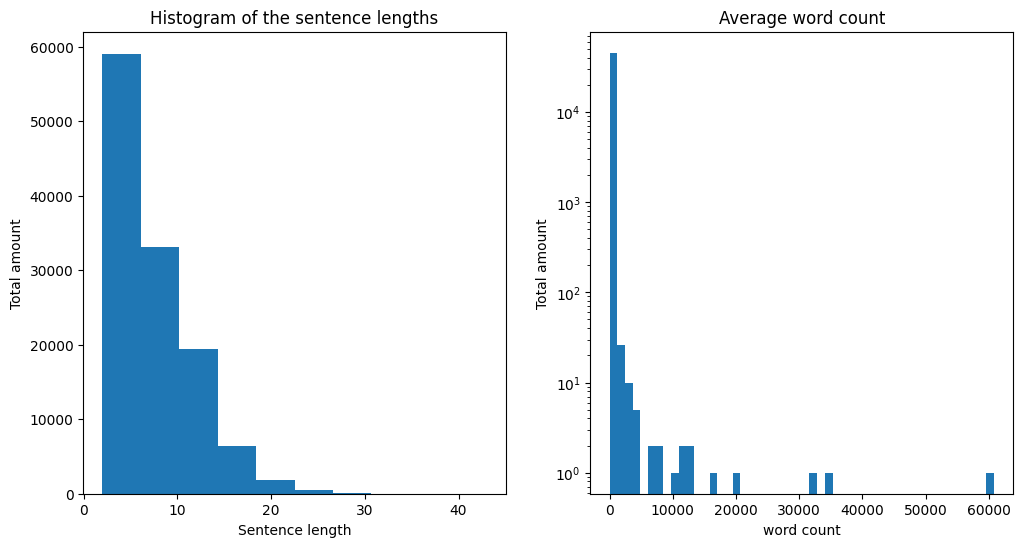

In [5]:
import matplotlib.pyplot as plt

# Analyzing tokenized sentences to track sentence lengths and word occurrences.
word2count = {}
sen_len = []
for sentence in tokenized_sentences:
    sen_len.append(len(sentence))
    for word in sentence:
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

sorted_word2vec = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)}

#Plot the histogram of sentence lenghts and average
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(sen_len)
plt.title("Histogram of the sentence lengths")
plt.xlabel("Sentence length")
plt.ylabel("Total amount")

plt.subplot(1, 2, 2)
plt.hist(list(sorted_word2vec.values()), bins=50, log=True)
plt.title("Average word count")
plt.xlabel("word count")
plt.ylabel("Total amount")

plt.show()

## Word Embedding:

We train the embedding using word2vec, a popular embedding developed by Google research, used to represent word as numerical vectors able to captures semantic relationships  based on their context in a given corpus.
The embeddings with a vector size of 30 a minimum sequence length of 5 and a contex windows of 10.


In [6]:
from gensim.models.word2vec import Word2Vec

# We create the embeddings with
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Tutotrial: https://colab.research.google.com/drive/13YPlY0OsP3d-4yJH4mIf9NWMom09FMt_

### Inspect the word2vec embeddings

In [11]:
#length of the vocabolary
print(f"Length of the vocabulary: {len(model.wv)}")

term = 'beyonce'
model.wv[term]

Length of the vocabulary: 12647


array([-1.6854529 ,  2.088995  , -0.96498084,  0.4969559 , -0.1825606 ,
       -0.26014838,  0.23146352, -0.3995416 , -1.1660998 , -0.9088764 ,
        2.4547646 , -3.1797826 , -0.4651893 , -0.6736508 , -0.4823739 ,
       -0.7367167 , -0.7044667 , -0.22239766, -0.8556888 , -0.25928435,
       -0.5447598 ,  0.30970475, -0.16375062, -2.6703207 , -0.16442692,
        0.2675117 , -0.42074588, -0.00486794,  0.2392299 ,  0.07938246],
      dtype=float32)

Test some common words from our dataset and check what words are considered to be close to them

In [22]:
term = 'beyonce'
print(f'Most similar embeddings to "{term}":')
print(np.array(model.wv.most_similar(term)))

Most similar embeddings to "beyonce":
[['kanye' '0.9383314847946167']
 ['madonna' '0.9059373140335083']
 ['chopin' '0.902431845664978']
 ['schwarzenegger' '0.8769072890281677']
 ['victoria' '0.8692107796669006']
 ['queen' '0.8677167892456055']
 ['destiny' '0.8655838370323181']
 ['album' '0.8554466366767883']
 ['she' '0.8380388617515564']
 ['death' '0.8348565697669983']]


In [24]:
term = 'bitumen'
print(f'Most similar embeddings to "{term}":')
print(np.array(model.wv.most_similar(term)))

Most similar embeddings to "bitumen":
[['accuracy' '0.9546747207641602']
 ['contrast' '0.9534364938735962']
 ['oxide' '0.9511854648590088']
 ['sensation' '0.9482064843177795']
 ['observed' '0.9477023482322693']
 ['alpha' '0.9471796751022339']
 ['duplication' '0.9466556310653687']
 ['willow' '0.9452981352806091']
 ['orphan' '0.9452633261680603']
 ['medium' '0.9446800947189331']]


In [26]:
term = 'coffee'
print(f'Most similar embeddings to "{term}":')
print(np.array(model.wv.most_similar(term)))

Most similar embeddings to "coffee":
[['tony' '0.9687963724136353']
 ['bosnia' '0.9681729078292847']
 ['conservatory' '0.9660211205482483']
 ['weber' '0.9639192223548889']
 ['featuring' '0.9630628824234009']
 ['herzegovina' '0.9629309773445129']
 ['crawford' '0.9626190066337585']
 ['thailand' '0.9614229798316956']
 ['competing' '0.9612274765968323']
 ['scythians' '0.9600880742073059']]


### Plot some embeddings

In [31]:
from sklearn.manifold import TSNE
import random

sample = random.sample(list(model.wv.key_to_index), 500)
word_vectors = model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [42]:
import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

# 2. Train and evaluate models:

The variable `semb_model` loads a pre-trained model transformer while instead
 `xenc_model` loads the pre-trained Crossencoder, designed to assess pairs of sentences and predict their semantic relatedness,a crucial task for effective question and answering.


In [ ]:
#  allows to work with pre-trained models.
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

The function creates an optimize the process of generating and storing embeddings by checking if precomputed embeddings are available in a cache file.
 If they are, it loads the embeddings, otherwise, it computes them and saves them to the cache for subsequent use.

In [ ]:
import os
import pickle

# Define hnswlib index path
embeddings_cache_path = './qa_embeddings_cache.pkl'

# Load cache if available
if os.path.exists(embeddings_cache_path):
    print('Loading embeddings cache')
    with open(embeddings_cache_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
# Else compute embeddings
else:
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(unique_contexts, convert_to_tensor=True, show_progress_bar=True)
    # Save the index to a file for future loading
    print(f'Saving index to: \'{embeddings_cache_path}\'')
    with open(embeddings_cache_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

We then employ an efficient index based on hnswlib and cosine similarities for nearest neighbor search, with a mechanism to save and load the index.

In [ ]:
import os
import hnswlib
import time
start = time.time()
# Create empthy index
index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = './qa_hnswlib_100.index'

# Load index if available
if os.path.exists(index_path):
    print('Loading index...')
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print('Start creating HNSWLIB index')
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=100, M=64) # see https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for parameter description
    # Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print(f'Saving index to: {index_path}')
    index.save_index(index_path)

end = time.time()
print(f"Exectution time: {int((end - start) / 60)}:{int((end - start) % 60)} min:sec")

In [ ]:
!pip install accelerate

Setting up the environment for working with a pre-trained T5 model by selecting the appropriate device (GPU or CPU), loading the T5 tokenizer, and loading the T5 model with specific configuration options such as device mapping and precision.


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)



#Demonstration of using the model for translation and pipeline for Q&A



In [ ]:
input_text = 'Translate the following sentence from Italian to English: "Amo la pizza"'

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0])
print(output_text)

We define a pipeline for question and answering: \\
Takes an user question, ensuring that it ends with "?" and by searching between the relevant documents based on the previous index, after we re-ranks them using the cross-encoder model, and generates the answer.

In [ ]:
def qa_pipeline(
    question, print_flag,
    similarity_model=semb_model,
    embeddings_index=index,
    re_ranking_model=xenc_model,
    generative_model=model,
    device=device
):
    if not question.endswith('?'):
        question = question + '?'
    # Embed question
    question_embedding = similarity_model.encode(question, convert_to_tensor=True)
    # Search documents similar to question in index
    corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=64)
    # Re-rank results
    xenc_model_inputs = [(question, unique_contexts[idx]) for idx in corpus_ids[0]]
    cross_scores = re_ranking_model.predict(xenc_model_inputs)
    # Get best matching passage
    passage_idx = np.argsort(-cross_scores)[0]
    passage = unique_contexts[corpus_ids[0][passage_idx]]
    # Encode input
    input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    if print_flag:
        print('INPUT TEXT:', input_text, "\n")
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_new_tokens=512)
    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Return result
    return output_text

In [ ]:
question = input("Ask a question >>> ")
print()

print(qa_pipeline(question, True))

Ask a question >>> hello

INPUT TEXT: Given the following passage, answer the related question.

Passage:

Kanye Omari West (/ˈkɑːnjeɪ/; born June 8, 1977) is an American hip hop recording artist, record producer, rapper, fashion designer, and entrepreneur. He is among the most acclaimed musicians of the 21st century, attracting both praise and controversy for his work and his outspoken public persona.

Q: hello? 

Kanye Omari West


# 3. Add voice interactivity:

# Text-to-Speech using NVIDIA Tacotron2 and WaveGlow
The code loads the Tacotron2 and WaveGlow models from NVIDIA's DeepLearningExamples repository. The models are transferred to the GPU if available and set to evaluation mode.
Utility functions for text-to-speech are loaded, including the text2speech function, which takes text input, converts it to a numeric sequence, generates a mel spectrogram using Tacotron2, and synthesizes audio using WaveGlow.

Text-to-Speech Function

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install numpy scipy librosa unidecode inflect openai-whisper

#### Load the tacotron and waveglow models from Torchhub

- Tacotron2 model produces mel spectrograms from text
- Waveglow model takes mel spectrogram and generates speech

Write some text and transform it to numeric sequence

### Define text2speech function using all the previous knowledge

The text2speech function is applied to the input text . It returns the audio signal and sampling rate. The audio is saved to a WAV file and played back using IPython's Audio display.



In [ ]:
import torch
from IPython.display import Audio
from scipy.io.wavfile import write
import whisper

# Load tacotron
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

# Load waveglow
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

# Load utils
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')


<!-- Text-to-Speech Function -->

Converts text input into audio signals using Tacotron 2 and WaveGlow models:

1. **Input Preparation:**
   - Transforms the text into a numeric sequence.

2. **Tacotron2 Inference:**
   - Generates a mel spectrogram from the numeric sequence.

3. **WaveGlow Synthesis:**
   - Produces an audio signal from the mel spectrogram.

4. **Output:**
   - Returns the audio signal (NumPy array) with a sampling rate of 22050.


In [ ]:
def text2speech(input):
    rate = 22050
    # Transform the text to numeric sequence
    sequences, lengths = utils.prepare_input_sequence([input])

    # Use tacotron2 model to create a mel spectrogram from the numeric sequence

    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)

    # Use the waveglow model to produce audio signal from the mel spectrogram
    with torch.no_grad():
        audio = waveglow.infer(mel)

    # return the audio signal
    audio_numpy = audio[0].data.cpu().numpy()

    return audio_numpy, rate

In [ ]:
text = "When did beyonce release dangerously in love?"

audio_numpy, rate = text2speech(text)

write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)

### Define speech2text function
Finally, the Whisper ASR model is loaded, and the generated audio file is transcribed. The transcribed text is printed.



In [ ]:
model = whisper.load_model("base")

result = model.transcribe("./audio.wav")
print(result["text"])

## Make something app like

In [ ]:
import random

pair = random.choice(pairs)
question = pair[0]
answer = pair[1]["text"]
print(f"Q: {question}")
print(f"A: {answer}")

output = qa_pipeline(question, 0)
print(f"Predicted: {output}")

audio_numpy, rate = text2speech(question)
print("question:")
Audio(audio_numpy, rate=rate, autoplay=True)



In [ ]:
audio_numpy, rate = text2speech(output)
print("Predicted:")
Audio(audio_numpy, rate=rate)


# Hugging face model


<!-- Question Answering with Hugging Face Transformers -->

Utilizes Hugging Face Transformers for question-answering:
- a) Uses a convenient pipeline for quick predictions.
- b) Loads the model and tokenizer separately for customization.


In [10]:
from transformers import pipeline

model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)


<!-- Randomized Question-Answering Evaluation -->

Select a random question, answer pair from our data, and send it to the model and see how well the answer matches the ground truth


In [24]:
import random

# Choose random index
idx = random.randint(0,len(pairs)-1)
pair = pairs[idx]

# Get the answer and the answer
question = pair[0]
answer = pair[1]["text"]
print(f"Q: {question}")
print(f"A: {answer}")

# Create a context for the model
QA_input = {
    'question': question,
    'context': contexts[idx]
}

res = nlp(QA_input)
print(res["answer"])

Q: What does an upstream ISP provide for an ISP?
A: access to parts of the Internet the contracting ISP by itself has no access to
access to parts of the Internet the contracting ISP by itself has no access to
